In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
np.random.seed(42)

# Portfolio Planner

In this activity, you will use the iexfinance api to grab historical data for a 60/40 portfolio using `SPY` to represent the stock portion and `AGG` to represent the bonds.

In [3]:
from iexfinance.stocks import get_historical_data
import iexfinance as iex

In [4]:
#http://finance.yahoo.com/q?s=AAPL

# Data Collection

In this step, you will need to use the IEX api to fetch closing prices for the `SPY` and `AGG` tickers. Save the results as a pandas DataFrame

In [5]:
list_of_tickers = ["SPY", "AGG"]

# Set start and end datetimes of 1 year, between now and 365 days ago.
end_date = datetime.now()
start_date = end_date + timedelta(-365)

# Get 1 year's worth of historical data for SPY
spy_df = get_historical_data(list_of_tickers[0], start_date, end_date, close_only=True, output_format='pandas')
spy_df.drop(['volume'],axis='columns',inplace=True)

# Get 1 year's worth of historical data for AGG
agg_df = get_historical_data(list_of_tickers[1], start_date, end_date, close_only=True, output_format='pandas')
agg_df.drop(['volume'],axis='columns',inplace=True)

close_df = pd.concat([spy_df,agg_df], join='inner', axis='columns')

close_df.columns = ['SPY','AGG']

close_df.head()

,SPY,AGG
date,,
2019-01-28,263.76,106.62
2019-01-29,263.41,106.90
2019-01-30,267.58,107.14
2019-01-31,269.93,107.46
2019-02-01,270.06,106.97


# Monte Carlo Simulation

In this step, you will run Monte Carlo Simulations for your portfolio to model portfolio performance at different retirement ages. 

Complete the following steps:
1. Calculate the daily returns for the SPY and AGG closing prices.
2. Calculate volatility for both the SPY and AGG closing prices.
3. Find the last day's closing price for both stocks and save those as variables.
4. Run a Monte Carlo Simulation of at least 500 iterations and generate at least 30 years of closing prices

### HINTS:
There are 252 trading days per year, so the number of records to generate for each Monte Carlo run will be 252 days * 30 years

In [7]:
# Calculate the daily roi for the stocks
returns_df = close_df.pct_change().dropna()

avg_daily_return_spy = returns_df.mean()['SPY']
avg_daily_return_agg = returns_df.mean()['AGG']


avg_daily_return_agg

0.00027375476127896605

In [8]:
# Calculate volatility
std_dev_daily_return_spy = returns_df.std()['SPY']
std_dev_daily_return_agg = returns_df.std()['AGG']

std_dev_daily_return_agg

0.002094524695851093

In [12]:
# Save the last day's closing price
spy_last_price = returns_df['SPY'][-1]
agg_last_price = returns_df['AGG'][-1]

In [19]:
# Setup the Monte Carlo Parameters
number_simulations = 500
number_records = 252 * 30
monte_carlo = pd.DataFrame()
portfolio_cumulative_returns = pd.DataFrame()

In [21]:
# Run the Monte Carlo Simulation
for x in range(number_simulations):
    
    # Initialize the simulated prices list with the last closing price of `SPY` and `AGG`
    simulated_spy_prices = [spy_last_price]
    simulated_agg_prices = [agg_last_price]
    
    # Simulate the returns for 252 * 3 days
    for i in range(number_records):
        
        # Calculate the simulated price using the last price within the list
        simulated_spy_price = simulated_spy_prices[-1] * (1 + np.random.normal(avg_daily_return_spy, std_dev_daily_return_spy))
        simulated_agg_price = simulated_agg_prices[-1] * (1 + np.random.normal(avg_daily_return_agg, std_dev_daily_return_agg))
        
        # Append the simulated price to the list
        simulated_spy_prices.append(simulated_spy_price)
        simulated_agg_prices.append(simulated_agg_price)
    
    # Append a simulated prices of each simulation to DataFrame
    monte_carlo["SPY prices"] = pd.Series(simulated_spy_prices)
    monte_carlo["AGG prices"] = pd.Series(simulated_agg_prices)
    
    # Calculate the daily returns of simulated prices
    simulated_daily_returns = monte_carlo.pct_change()
    
    # Set the portfolio weights (60% SPY; 40% AGG)
    weights = [0.60, 0.40]

    # Use the `dot` function with the weights to multiply weights with each column's simulated daily returns
    portfolio_daily_returns = simulated_daily_returns.dot(weights)
    
    # Calculate the normalized, cumulative return series
    portfolio_cumulative_returns[x] = (1 + portfolio_daily_returns.fillna(0)).cumprod()

# Print records from the DataFrame
portfolio_cumulative_returns.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.005439,1.006493,1.008858,0.996775,1.001805,0.999272,1.002716,1.000636,1.007361,0.999478,...,0.997900,1.003015,0.996560,0.994421,1.002971,0.997557,1.001414,1.000414,0.996477,0.999914
2,1.008586,0.998097,1.003741,0.986887,1.001149,1.007256,0.999342,1.000480,0.997385,0.997184,...,0.999344,1.000054,0.996212,0.994942,1.002983,1.001230,0.998795,0.993666,0.994692,0.998378
3,1.008070,1.001031,1.007529,0.981325,1.001058,1.015133,1.007026,0.998348,0.998540,0.996012,...,0.993240,0.999027,0.999873,1.000264,1.006284,1.000288,0.997092,0.992947,0.994163,0.996727
4,1.009652,0.996491,1.006538,0.978788,1.008599,1.005794,1.015724,0.997709,1.007217,0.990798,...,0.999157,0.996321,0.994686,1.001074,1.010651,1.003701,0.999675,0.993066,0.999363,1.002971


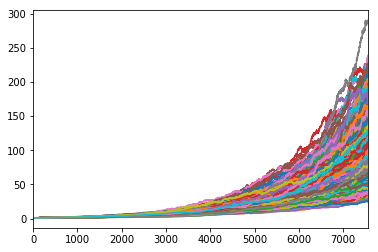

In [23]:
# Visualize the Simulation
portfolio_cumulative_returns.plot(legend=None)

In [29]:
# Select the last row for the cumulative returns (cumulative returns at 30 years)
ending_cumulative_returns = portfolio_cumulative_returns.iloc[-1, :]
ending_cumulative_returns.head()

0    118.235745
1     96.921071
2    112.441703
3    174.933398
4    121.966198
Name: 7560, dtype: float64

In [30]:
# Select the last row for the cumulative returns (cumulative returns at 20 years)
ending_cumulative_returns_20 = portfolio_cumulative_returns.iloc[-2519, :]
ending_cumulative_returns_20.head()

0    25.164168
1    20.009425
2    20.260119
3    51.631232
4    20.316466
Name: 5042, dtype: float64

In [41]:
# Display the 90% confidence interval for the ending returns
confidence_interval = ending_cumulative_returns.quantile(q=[0.05, 0.95])
confidence_interval

# 50% confidence interval
confidence_interval_50 = ending_cumulative_returns.quantile(q=[.5])
confidence_interval_50

0.5    93.582147
Name: 7560, dtype: float64

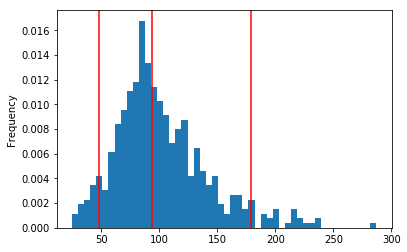

In [42]:
# Visualize the distribution of the ending returns
plt.figure();
ending_cumulative_returns.plot(kind='hist', density=True, bins=50)
plt.axvline(confidence_interval.iloc[0], color='r')
plt.axvline(confidence_interval.iloc[1], color='r')
plt.axvline(confidence_interval_50.iloc[0], color='r')

---

# Retirement Analysis

In this section, you will use the monte carlo model to answer the following retirement planning questions:

1. What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?
2. Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?
3. Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?
4. How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

### What are the expected cumulative returns at 30 years for the 10th, 50th, and 90th percentiles?

In [47]:
print('At the 10th percentile, the expected cumulative return is ~49%')
print('At the 50th percentile, the expected cumulative return is ~95%')
print('At the 90th percentile, the expected cumulative return is ~180%')

At the 10th percentile, the expected cumulative return is ~49%
At the 50th percentile, the expected cumulative return is ~95%
At the 90th percentile, the expected cumulative return is ~180%


### Given an initial investment of `$20,000`, what is the expected portfolio return in dollars at the 10th, 50th, and 90th percentiles?

In [51]:
print(f'At the 10th percentile, the expected portfolio return is ${int(20000*.49)}')
print(f'At the 10th percentile, the expected portfolio return is ${int(20000*.95)}')
print(f'At the 10th percentile, the expected portfolio return is ${int(20000*.180)}')

At the 10th percentile, the expected portfolio return is $9800
At the 10th percentile, the expected portfolio return is $19000
At the 10th percentile, the expected portfolio return is $3600


### Given the current projected annual income from the Plaid analysis, will a 4% withdraw rate from the retirement portfolio meet or exceed that value at the 10th percentile?

Note: This is effectively saying that 90% of the expected returns will be greater than the return at the 10th percentile, so this can help measure the uncertainty about having enough funds at retirement

In [52]:
print('Total income after 30 years at 10th percentile with a $20,000 investment:')
_10th_pct_income = 20000*1.49
print(_10th_pct_income)
print('Total withdrawal of 4% per year over 30 years:')
withdrawal = 20000*.04*30
print(withdrawal)

if _10th_pct_income > withdrawal:
    print('The retirement portfolio will exceed the value of the cumulative withdrawals.')
else:
    print('The retirement portfolio will NOT exceed the value of the cumulative withdrawals.')



Total income after 30 years at 10th percentile with a $20,000 investment:
29800.0
Total withdrawal of 4% per year over 30 years:
24000.0
The retirement portfolio will exceed the value of the cumulative withdrawals.


### How would a 50% increase in the initial investment amount affect the 4% retirement withdrawal?

In [53]:
print('Total income after 30 years at 10th percentile with a $20,000 investment:')
_10th_pct_income_50 = 30000*1.49
print(_10th_pct_income)
print('Total withdrawal of 4% per year over 30 years:')
withdrawal_50 = 30000*.04*30
print(withdrawal)

if (withdrawal_50/30000) == (withdrawal/20000):
    print('A 50% increase will have NO effect on the withdrawal.')
else:
    print('A 50% increase will have an effect on the withdrawal.')

Total income after 30 years at 10th percentile with a $20,000 investment:
29800.0
Total withdrawal of 4% per year over 30 years:
24000.0
A 50% increase will have NO effect on the withdrawal.


### Optional Challenge

In this section, you will calculate and plot the cumulative returns for the median and 90% confidence intervals. This plot shows the expected cumulative returns for any given day between the first day and the last day of investment. 

In [ ]:
# YOUR CODE HERE